<a href="https://colab.research.google.com/github/mrzResearchArena/Anticancer-Peptides-CNN/blob/master/ACP-740-ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/ACP-PyFeat'

/content/drive/My Drive/ACP-PyFeat


In [4]:
ls

bits-164.npy    blosum-500.npy  model-240.png      PyFeat-500-20.npy
bits-240.npy    blosum-740.npy  model-740.png      PyFeat-500.npy
bits-500.npy    bpf-164.npy     PyFeat-164-20.npy  PyFeat-740-20.npy
bits-740.npy    bpf-240.npy     PyFeat-164.npy     PyFeat-740.npy
blosum-164.npy  bpf-500.npy     PyFeat-240-20.npy  ROC-240.png
blosum-240.npy  bpf-740.npy     PyFeat-240.npy     ROC.png


### [2]. Load Deep Learning API (Keras):

In [5]:
# # Initialize TF-2.x:
# try:
#     %tensorflow_version 2.x  # Colab only.
# except Exception:
#     pass

# import tensorflow as tf
# print('We\'re using TF-{}.'.format(tf.__version__))

# # Colab Auto Click: [https://paste.ubuntu.com/p/R78fGBJbjb/]

In [6]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.3.0.


In [7]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

In [8]:
def rocPlot(TPR, meanFPR):
    plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')
    meanTPR = np.mean(TPR, axis=0)
    meanAUC = auc(meanFPR, meanTPR)
    plt.plot(meanFPR, meanTPR, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (meanAUC),lw=2, alpha=1)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
    plt.legend(loc="lower right")
    plt.savefig('ROC-740.png')
    plt.show()
#end-def

### [3]. Load Datasets:

In [9]:
T = 15 # terminus_length

X1 = np.load('bpf-740.npy')
X2 = np.load('bits-740.npy')
X3 = np.load('blosum-740.npy')


X1 = X1[:,0:T,:]
X2 = X2[:,0:T,:]
X3 = X3[:,0:T,:]


Y  = [1 for _ in range(376)]
Y += [0 for _ in range(364)]

Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(740, 15, 20)
(740, 15, 31)
(740, 15, 20)
(740, 2)


### [4]. Generate Model:

In [10]:
### Model-740

def Network():
    ### Head-1:
    input1 = Input(shape=X1[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=X2[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=X3[0].shape)
    
    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head3 = Flatten()(x)


    # merge
    merge = Concatenate()([head1, head2, head3])

    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.70)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 20)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15, 31)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15, 20)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 10)       810         input_1[0][0]                    
_______________________________________________________________________________________

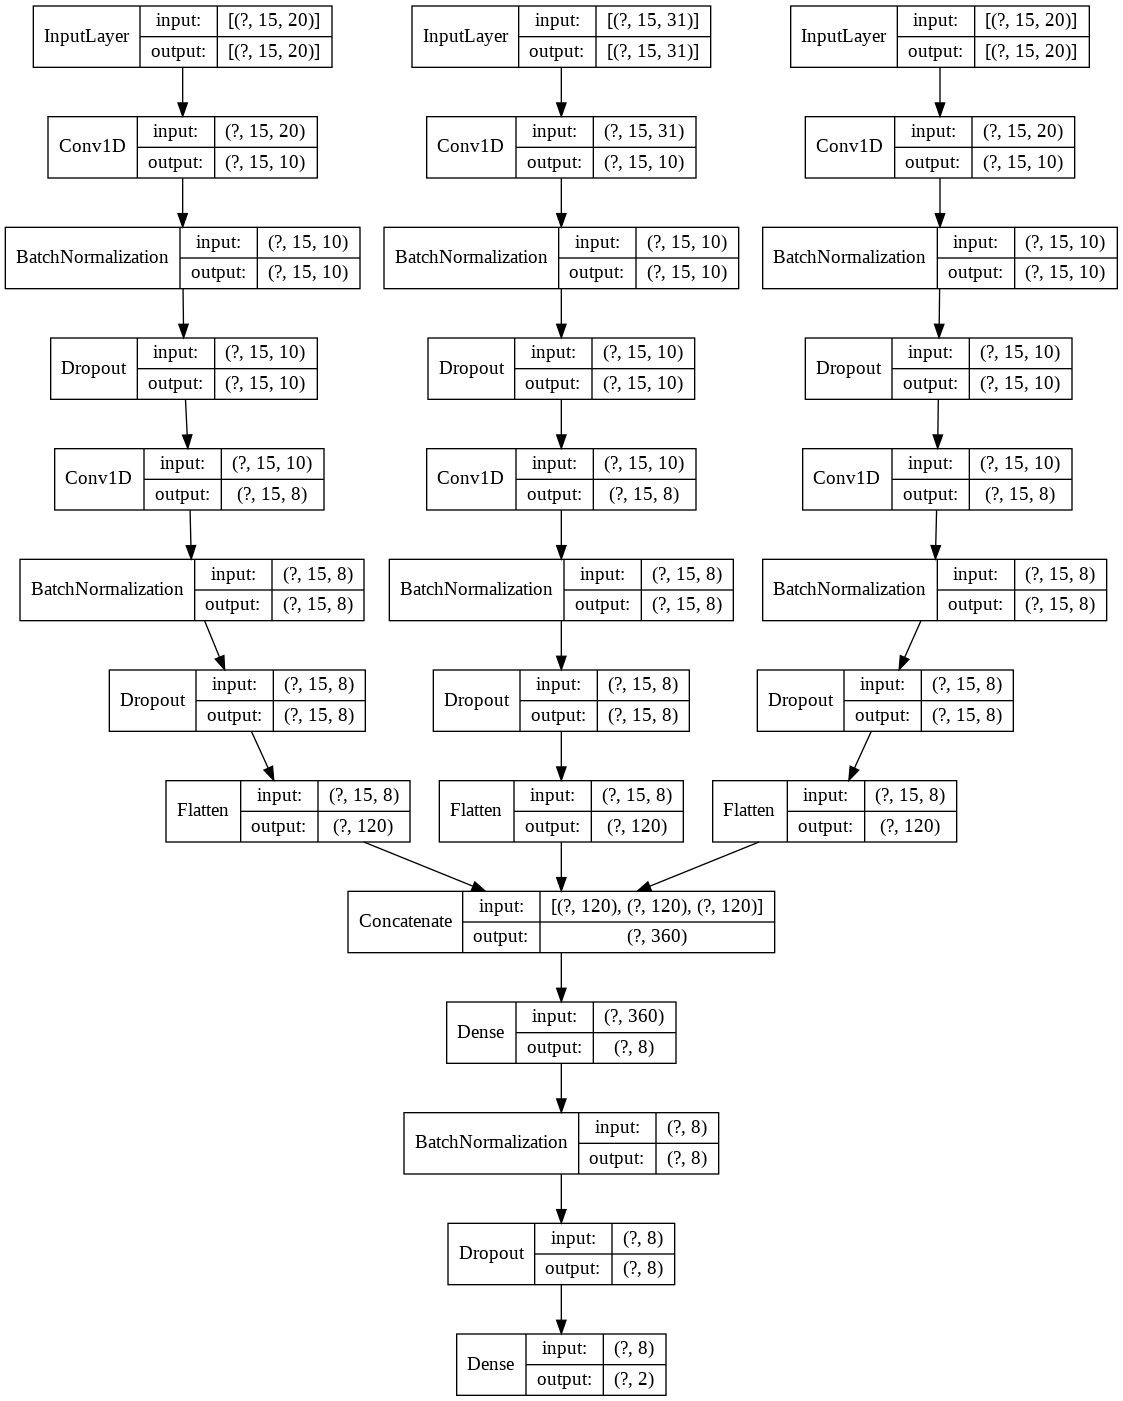

In [11]:
model = Network()
model.summary()
plot_model(model, to_file='model-740.png', show_shapes=True, show_layer_names=False, expand_nested=True)

### [5]. Run Model:

Epoch 1/500
74/74 [==============================] - 1s 11ms/step - loss: 1.7053 - accuracy: 0.5169 - val_loss: 1.3822 - val_accuracy: 0.5000
Epoch 2/500
74/74 [==============================] - 0s 6ms/step - loss: 1.4142 - accuracy: 0.4949 - val_loss: 1.3127 - val_accuracy: 0.4932
Epoch 3/500
74/74 [==============================] - 1s 7ms/step - loss: 1.2738 - accuracy: 0.5236 - val_loss: 1.2199 - val_accuracy: 0.4932
Epoch 4/500
74/74 [==============================] - 0s 6ms/step - loss: 1.1947 - accuracy: 0.5253 - val_loss: 1.1480 - val_accuracy: 0.4932
Epoch 5/500
74/74 [==============================] - 1s 7ms/step - loss: 1.1080 - accuracy: 0.5405 - val_loss: 1.0701 - val_accuracy: 0.4797
Epoch 6/500
74/74 [==============================] - 0s 7ms/step - loss: 1.0259 - accuracy: 0.5895 - val_loss: 1.0161 - val_accuracy: 0.5338
Epoch 7/500
74/74 [==============================] - 1s 7ms/step - loss: 0.9908 - accuracy: 0.6098 - val_loss: 0.9584 - val_accuracy: 0.6014
Epoch 8/500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 11ms/step - loss: 1.6459 - accuracy: 0.5203 - val_loss: 1.3424 - val_accuracy: 0.5203
Epoch 2/500
74/74 [==============================] - 0s 7ms/step - loss: 1.3370 - accuracy: 0.5389 - val_loss: 1.2454 - val_accuracy: 0.6351
Epoch 3/500
74/74 [==============================] - 0s 7ms/step - loss: 1.2228 - accuracy: 0.5439 - val_loss: 1.1495 - val_accuracy: 0.5338
Epoch 4/500
74/74 [==============================] - 0s 6ms/step - loss: 1.1196 - accuracy: 0.4966 - val_loss: 1.0695 - val_accuracy: 0.5541
Epoch 5/500
74/74 [==============================] - 0s 7ms/step - loss: 1.0265 - accuracy: 0.5389 - val_loss: 1.0120 - val_accuracy: 0.4865
Epoch 6/500
74/74 [==============================] - 0s 6ms/step - loss: 0.9807 - accuracy: 0.5355 - val_loss: 0.9729 - val_accuracy: 0.5608
Epoch 7/500
74/74 [==============================] - 1s 7ms/step - loss: 0.9505 - accuracy: 0.5541 - val_loss: 0.9181 - val_accuracy: 0.6351
Epoch 8/500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 14ms/step - loss: 2.0234 - accuracy: 0.5203 - val_loss: 1.4052 - val_accuracy: 0.5473
Epoch 2/500
74/74 [==============================] - 0s 7ms/step - loss: 1.5460 - accuracy: 0.5591 - val_loss: 1.3579 - val_accuracy: 0.5878
Epoch 3/500
74/74 [==============================] - 0s 7ms/step - loss: 1.3631 - accuracy: 0.5676 - val_loss: 1.2984 - val_accuracy: 0.5541
Epoch 4/500
74/74 [==============================] - 0s 7ms/step - loss: 1.2962 - accuracy: 0.5338 - val_loss: 1.2307 - val_accuracy: 0.5946
Epoch 5/500
74/74 [==============================] - 0s 7ms/step - loss: 1.1824 - accuracy: 0.5828 - val_loss: 1.1557 - val_accuracy: 0.5946
Epoch 6/500
74/74 [==============================] - 0s 6ms/step - loss: 1.1240 - accuracy: 0.5659 - val_loss: 1.0865 - val_accuracy: 0.6689
Epoch 7/500
74/74 [==============================] - 0s 7ms/step - loss: 1.0818 - accuracy: 0.6030 - val_loss: 1.0357 - val_accuracy: 0.6419
Epoch 8/500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 10ms/step - loss: 1.8336 - accuracy: 0.4814 - val_loss: 1.3490 - val_accuracy: 0.6757
Epoch 2/500
74/74 [==============================] - 0s 7ms/step - loss: 1.3807 - accuracy: 0.5389 - val_loss: 1.2811 - val_accuracy: 0.6824
Epoch 3/500
74/74 [==============================] - 0s 7ms/step - loss: 1.2860 - accuracy: 0.5405 - val_loss: 1.2189 - val_accuracy: 0.6824
Epoch 4/500
74/74 [==============================] - 0s 7ms/step - loss: 1.1949 - accuracy: 0.4983 - val_loss: 1.1333 - val_accuracy: 0.6554
Epoch 5/500
74/74 [==============================] - 0s 7ms/step - loss: 1.1045 - accuracy: 0.5304 - val_loss: 1.0562 - val_accuracy: 0.6824
Epoch 6/500
74/74 [==============================] - 0s 7ms/step - loss: 1.0320 - accuracy: 0.5321 - val_loss: 0.9886 - val_accuracy: 0.5743
Epoch 7/500
74/74 [==============================] - 1s 7ms/step - loss: 0.9731 - accuracy: 0.5794 - val_loss: 0.9364 - val_accuracy: 0.6892
Epoch 8/500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Epoch 1/500
74/74 [==============================] - 1s 10ms/step - loss: 1.6511 - accuracy: 0.5000 - val_loss: 1.3414 - val_accuracy: 0.5203
Epoch 2/500
74/74 [==============================] - 0s 7ms/step - loss: 1.3171 - accuracy: 0.5439 - val_loss: 1.2428 - val_accuracy: 0.5203
Epoch 3/500
74/74 [==============================] - 0s 6ms/step - loss: 1.1793 - accuracy: 0.5642 - val_loss: 1.1327 - val_accuracy: 0.5068
Epoch 4/500
74/74 [==============================] - 1s 7ms/step - loss: 1.0933 - accuracy: 0.5405 - val_loss: 1.0409 - val_accuracy: 0.5203
Epoch 5/500
74/74 [==============================] - 0s 6ms/step - loss: 0.9950 - accuracy: 0.5794 - val_loss: 0.9600 - val_accuracy: 0.5676
Epoch 6/500
74/74 [==============================] - 0s 6ms/step - loss: 0.9302 - accuracy: 0.6047 - val_loss: 0.9221 - val_accuracy: 0.5878
Epoch 7/500
74/74 [==============================] - 0s 7ms/step - loss: 0.9297 - accuracy: 0.5642 - val_loss: 0.8838 - val_accuracy: 0.5946
Epoch 8/500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


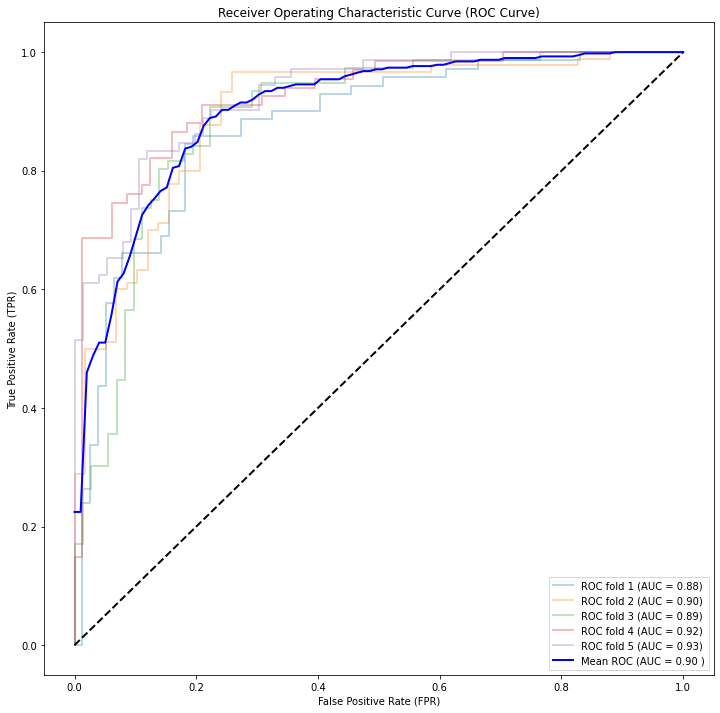

[0.8108108043670654, 0.837837815284729, 0.8310810923576355, 0.837837815284729, 0.8310810923576355]
Accuracy: 0.83
Sensitivity: 0.8691
Specificity: 0.7875
MCC: 0.6580
Precision: 0.8076


In [15]:
setEpochNumber     = 500     # Performed-welled in epoch 600.
setBatchSizeNumber = 8
####################################################

cv = KFold(n_splits=5, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# ROC Curve:
fig1 = plt.figure(figsize=[12,12])

TPR = []
meanFPR = np.linspace(0, 1, 100)

i = 1

# CM = np.array([
#      [0, 0],
#      [0, 0],
# ], dtype=int)

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(lr=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=[X1[train,:,:], X2[train,:,:], X3[train,:,:]],
                        y=Y[train,:],
                        validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:],], Y[test,:]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        verbose=1,
                        callbacks=[])

    # Evaluate the Model:
    accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:])
    Accuracy.append(accuracy[1])
    
    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
    v = Yp
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(Yactual, v[:,1])
    TPR.append(interp(meanFPR, fpr, tpr))
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
    i= i+1
    
    # # Performance Plot
    # print('#################################################')
    # print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    # lossPlot(results)
    # accuracyPlot(results)
    # print('#################################################')

#end-for

rocPlot(TPR, meanFPR)

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))